In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
%pylab inline 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv', parse_dates=['TradeDateTime'])

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## ML for prediction

In [3]:
sell = df["BuySell"] == "Sell"
buy = df["BuySell"] == "Buy"
do = df["TradeStatus"] == "Done"
ta = df["TradeStatus"] == "TradedAway"
resp = df["BNPPAnsweredQuote"] > 0
ab = df["Bid2Mid"] > 0
idx = buy & (do | ta) & resp & ab
X = df.ix[idx, ["BNPPAnsweredQuote", "RFQCompositePrice", "Bid2Mid"]]
X = (X["BNPPAnsweredQuote"] - X["RFQCompositePrice"]) / np.abs(X["Bid2Mid"])
y = df.ix[idx, "TradeStatus"]

In [4]:
xmin, xmax = X.quantile([.022, .9])
print xmin, xmax

-5.67566366389 5.87672519732


In [5]:
idx  = (X > xmin) & (X < xmax)
X = np.array([X.ix[idx]]).T
y = [1 if l == "Done" else 0 for l in y.ix[idx]]

In [6]:
print "baseline = %.2f" % ((len(y) - sum(y)) / float(len(y)) * 100)

baseline = 63.09


In [7]:
N = [5, 10, 50, 100, 500]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for n_neighbors in N:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    this_scores = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=N)

[ 0.65680085  0.65609151  0.65527576  0.65509842  0.65671218]
[ 0.67261926  0.67589998  0.67432169  0.67394928  0.67334634]
[ 0.68680617  0.68852633  0.68843767  0.68810073  0.68877461]
[ 0.68895194  0.68994503  0.6885086   0.68969675  0.68873914]
[ 0.6885618   0.69304841  0.69148785  0.69159425  0.6906721 ]


In [8]:
knn_best_score = scores.mean(axis=0).max()
print knn_best_score

0.691072885263


In [9]:
n_neighbors = 500
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X, y)

x = np.array([np.arange(-5, 5, .1)]).T
knn_pred = knn.predict_proba(x)

In [10]:
L = [1e-10, 1e-5, 1e-2, 1e-1, 1, 10]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for l in L:
    clf = LogisticRegression(penalty='l2', C=l)
    this_scores = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
lr_scores = pd.DataFrame(np.array(scores).T, columns=L)

[ 0.6885086   0.69088491  0.69047703  0.68978542  0.69159425]
[ 0.68898741  0.69299521  0.69118638  0.69161199  0.69173612]
[ 0.68721405  0.69120411  0.69017556  0.6906721   0.69070757]
[ 0.68730271  0.69120411  0.6902465   0.6906189   0.69070757]
[ 0.68730271  0.69118638  0.6902465   0.6906189   0.69068984]
[ 0.68730271  0.69118638  0.6902465   0.6906189   0.69068984]


In [11]:
lr_best_score = lr_scores.mean(axis=0).max()
print lr_best_score

0.691303422593


In [12]:
lr = LogisticRegression(penalty='l2', C=l)
lr.fit(X, y)

x = np.array([np.arange(-5, 5, .1)]).T
lr_pred = lr.predict_proba(x)

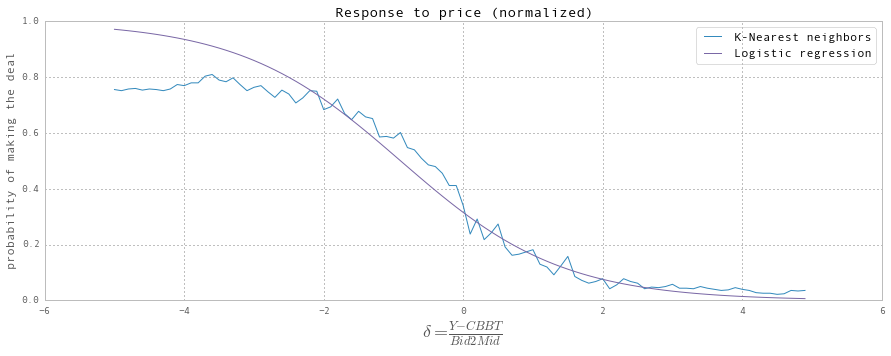

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(x, np.array([knn_pred[:, 1], lr_pred[:, 1]]).T)
plt.legend(["K-Nearest neighbors", "Logistic regression", ])
plt.title("Response to price (normalized)")
plt.xlabel(r"$\delta = \frac{Y - CBBT}{Bid2Mid}$", size=18) 
plt.ylabel("probability of making the deal")
plt.show()

## More features

In [14]:
from sklearn.feature_extraction import DictVectorizer

sell = df["BuySell"] == "Sell"
buy = df["BuySell"] == "Buy"
do = df["TradeStatus"] == "Done"
ta = df["TradeStatus"] == "TradedAway"
resp = df["BNPPAnsweredQuote"] > 0
ab = df["Bid2Mid"] > 0
mat =  ~np.isnan(df['Maturity']).values
idx = buy & (do | ta) & resp & ab & mat


X2 = pd.DataFrame()
X2["delta"] = (df.ix[idx, "BNPPAnsweredQuote"] - df.ix[idx, "RFQCompositePrice"]) / np.abs(df.ix[idx, "Bid2Mid"])
X2["NbDealers"] = df.ix[idx, "NbDealers"]
X2["sectors"] = df.ix[idx, u'Sector']
X2['RiskCaptain'] = df.ix[idx, 'RiskCaptain']
# X2['NotionalEUR'] = df.ix[idx, 'NotionalEUR']
X2['Rating'] = df.ix[idx, 'Rating']
X2['Ticker'] = df.ix[idx, 'Ticker']
X2['ClientTier'] = df.ix[idx, 'ClientTier']
X2['Customer'] = df.ix[idx, 'Customer']
X2['Maturity'] = df.ix[idx, 'Maturity']
X2['Trader'] = df.ix[idx, 'Trader']

X2["Status"] = np.array([1 if l == "Done" else 0 for l in df.ix[idx, "TradeStatus"]], dtype=np.float32)

xmin, xmax = X2['delta'].quantile([.022, .9])
print xmin, xmax
q  = (X2["delta"] > xmin) & (X2["delta"] < xmax)
X2 = X2.ix[q, :]

cat_feat = ["NbDealers", "sectors", 'RiskCaptain', 'Rating', 'Ticker', 'ClientTier', 'Customer', 'Maturity', 'Trader']

X2.fillna('NA')
for feat in cat_feat:
    X2[feat] = X2[feat].map(str)

-5.67612187461 5.87583528682


In [15]:
X2.head()

,delta,NbDealers,sectors,RiskCaptain,Rating,Ticker,ClientTier,Customer,Maturity,Trader,Status
1,-1.242737,1.0,Bank,FINANCIALS,NR,NDB,TIER 2,36,6.0,1,1
12,-1.842590,5.0,Bank,FINANCIALS,OTHER,LLOYDS,TIER 2,376,6.0,1,1
17,-0.250000,2.0,Bank,FINANCIALS,OTHER,BACR,TIER 3,28,5.0,7,1
28,0.279968,5.0,Bank,FINANCIALS,OTHER,ACAFP,TIER 2,473,34.0,3,0
30,0.714374,5.0,Bank,FINANCIALS,A+,BNP,TIER 2,4,4.0,1,0


In [16]:
d = DictVectorizer()
XOHE = d.fit_transform(X2.T.to_dict().values())
XOHE = pd.DataFrame(XOHE.todense(), columns=d.get_feature_names())

In [17]:
print XOHE.shape
print X2.shape
XOHE.head()

(187962, 2444)
(187962, 11)


,ClientTier=TIER 1,ClientTier=TIER 2,ClientTier=TIER 3,ClientTier=nan,Customer=1,Customer=10,Customer=100,Customer=1000,Customer=1001,Customer=1002,...,sectors=Public,sectors=Railways,sectors=Regional,sectors=Sovereign,sectors=Special Purpose,sectors=Supra-National,sectors=Telecom,sectors=Tobacco,sectors=Water,sectors=nan
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
L = [1e-10, 1e-5, 1e-2, 1e-1, 1]

y = XOHE["Status"].values
X = XOHE.drop("Status", 1).values

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for l in L:
    clf = LogisticRegression(penalty='l2', C=l)
    this_scores = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=L)

[ 0.68144496  0.68320062  0.6853819   0.68155137  0.68181738]
[ 0.70373654  0.70545674  0.70659171  0.70375428  0.70391388]
[ 0.77142705  0.77231375  0.77318271  0.77256202  0.77284577]
[ 0.77433542  0.77499158  0.77641029  0.77580734  0.77587827]
[ 0.77438862  0.7746369   0.7775098   0.77688911  0.77683591]


In [19]:
best_score = scores.mean(axis=0).max()
print best_score

0.776052066892


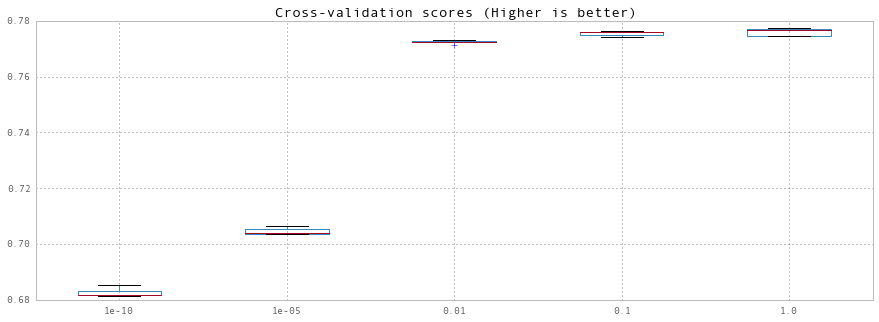

In [20]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

In [21]:
lr = LogisticRegression(penalty='l2', C=1)
lr.fit(X, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [22]:
c = pd.DataFrame(lr.coef_, columns=XOHE.drop("Status", 1).columns)

In [56]:
cols = filter(lambda x: 'NbDealers' in x, c.columns)

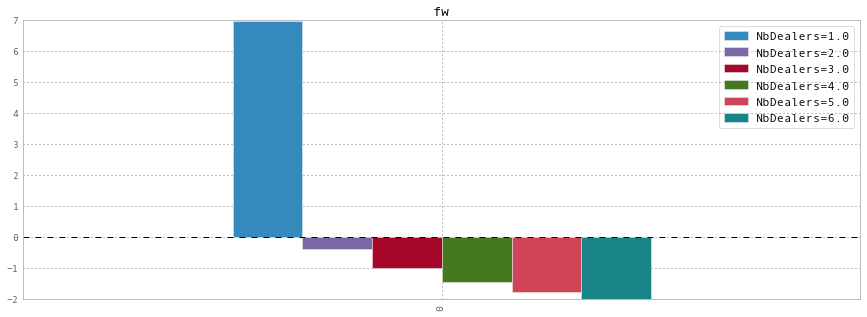

In [57]:
c.ix[:, cols].plot(kind='bar', figsize=(15, 5))
plt.title("fw")
plt.show()

In [25]:
cols = filter(lambda x: 'sectors' in x, c.columns)

In [26]:
list(c.ix[:, cols].columns[(c.ix[:, cols] > 0).values[0]])

['sectors=Aero/Defense',
 'sectors=Chemicals/Healthcare',
 'sectors=Clothing/Luxury',
 'sectors=Corporate',
 'sectors=Covered',
 'sectors=Financial',
 'sectors=Food/Beverages',
 'sectors=Gaming',
 'sectors=Government',
 'sectors=Media & Cable',
 'sectors=Metals',
 'sectors=Oil Coal Gas',
 'sectors=Paper/Packaging',
 'sectors=Property',
 'sectors=Regional',
 'sectors=Water']

In [27]:
list(c.ix[:, cols].columns[(c.ix[:, cols] < 0).values[0]])

['sectors=Agriculture',
 'sectors=Airline/Transport',
 'sectors=Auto/Components',
 'sectors=Bank',
 'sectors=Building/Mat/Construc',
 'sectors=Computers & IT',
 'sectors=Distrib/Retail',
 'sectors=Elect/House Appliances',
 'sectors=Electricity/Gas',
 'sectors=Financial Corporate',
 'sectors=Hotel/Catering',
 'sectors=Insurance',
 'sectors=Manufacturers & Services',
 'sectors=Other',
 'sectors=Power/Ind Equipment',
 'sectors=Public',
 'sectors=Railways',
 'sectors=Sovereign',
 'sectors=Special Purpose',
 'sectors=Supra-National',
 'sectors=Telecom',
 'sectors=Tobacco',
 'sectors=nan']

## Feature importance

In [28]:
sell = df["BuySell"] == "Sell"
buy = df["BuySell"] == "Buy"
do = df["TradeStatus"] == "Done"
ta = df["TradeStatus"] == "TradedAway"
resp = df["BNPPAnsweredQuote"] > 0
ab = df["Bid2Mid"] > 0
mat =  ~np.isnan(df['Maturity']).values
idx = buy & (do | ta) & resp & ab & mat

X = pd.DataFrame()
# Price
X["delta"] = (df.ix[idx, "BNPPAnsweredQuote"] - df.ix[idx, "RFQCompositePrice"]) / np.abs(df.ix[idx, "Bid2Mid"])
X["NbDealers"] = df.ix[idx, "NbDealers"]
X["sectors"] = pd.Categorical(df.ix[idx, u'Sector']).codes
X['RiskCaptain'] = pd.Categorical(df.ix[idx, 'RiskCaptain']).codes
X['NotionalEUR'] = df.ix[idx, 'NotionalEUR']
X['Rating'] = pd.Categorical(df.ix[idx, 'Rating']).codes
X['Ticker'] = pd.Categorical(df.ix[idx, 'Ticker']).codes
X['ClientTier'] = pd.Categorical(df.ix[idx, 'ClientTier']).codes
X['Customer'] = pd.Categorical(df.ix[idx, 'Customer']).codes
X['Preference'] = pd.Categorical(df.ix[idx, 'Customer'].map(str) + df.ix[idx, 'Ticker']).codes
X['Maturity'] = pd.Categorical(df.ix[idx, 'Maturity'])
X['Trader'] = pd.Categorical(df.ix[idx, 'Trader'])

y = np.array([1 if l == "Done" else 0 for l in df.ix[idx, "TradeStatus"]])

print xmin, xmax
q  = (X["delta"] > xmin) & (X["delta"] < xmax)
X = X.ix[q, :]
y = y[q.values]

-5.67612187461 5.87583528682


In [29]:
N = [5, 10, 50, 100]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for n in N:
    clf = RandomForestClassifier(n_estimators=n)
    this_scores = cross_validation.cross_val_score(clf, X.values, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=N)

[ 0.73993155  0.74181135  0.74218376  0.73920445  0.73955913]
[ 0.75904875  0.75794925  0.75759457  0.75727536  0.75856993]
[ 0.76715317  0.7698842   0.76789799  0.76649701  0.7700438 ]
[ 0.77148025  0.77038075  0.76827041  0.76821721  0.7709305 ]


In [30]:
best_score = scores.mean(axis=0).max()
print best_score

0.769855822944


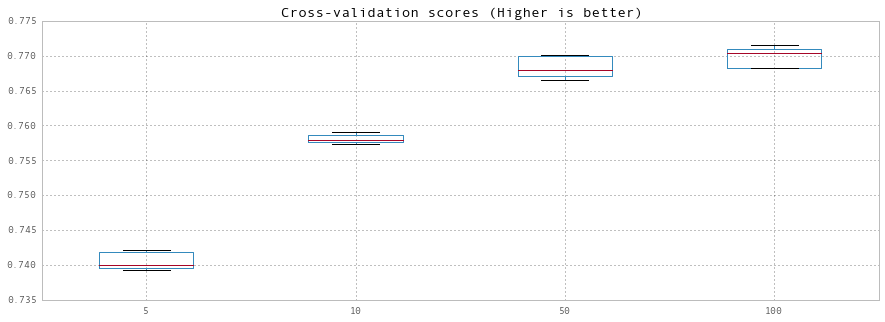

In [31]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

In [32]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

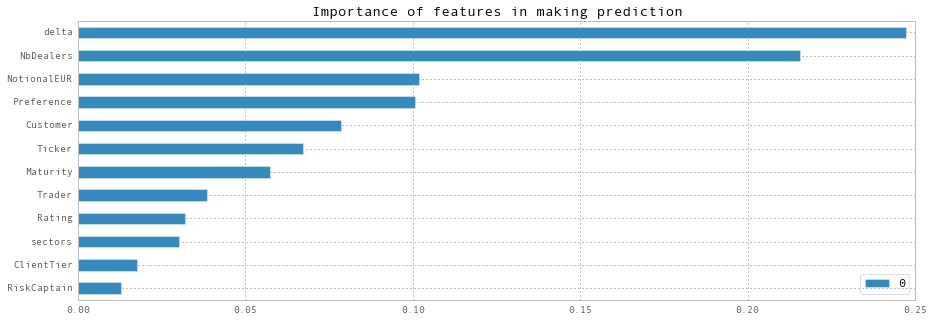

In [33]:
importance = pd.DataFrame(rf.feature_importances_, index=X.columns)
importance = importance.iloc[importance.ix[:, 0].argsort()]
importance.plot(kind='barh', figsize=(15, 5))
plt.title("Importance of features in making prediction")
plt.show()

## Recommendation

In [34]:
import pandas as pd
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [35]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv')

In [36]:
df['TradeDate'] = pd.to_datetime(df['TradeDate'], format='%Y%m%d')  # Transform date into real dates

In [37]:
nb_customers = len(set(df['Customer']))
nb_tickers = len(set(df['Ticker']))
row_idx = {tck: i for i, tck in enumerate(set(df['Ticker']))}

print nb_customers, nb_tickers

2030 1258


In [38]:
data = df.ix[df["BuySell"] == "Buy", [u'Customer', u'NotionalEUR', u'Ticker', u'TradeDate']]

In [39]:
data.head()

,Customer,NotionalEUR,Ticker,TradeDate
1,36,50000.000000,NDB,2014-10-02
2,203,1500000.000000,REPSM,2014-02-03
4,2,789016.884961,BACR,2014-10-02
6,2,789016.884961,ACAFP,2014-10-02
8,203,1000000.000000,EVKGR,2014-02-03


In [40]:
cut_date = pd.to_datetime('20140606', format='%Y%m%d')  # 2014-06-06 so that 75% of the data is used for train

data_train = data[data[u'TradeDate'] <= cut_date]
data_test = data[data[u'TradeDate'] > cut_date]

print "#train = %s" % data_train.shape[0]
print "#test = %s" % data_test.shape[0]

#train = 388385
#test = 156655


In [41]:
cut_count = 10
n_bins = 4
labels = range(1, n_bins + 1)

train_dense = data_train.groupby(['Customer', 'Ticker'])
train_dense = train_dense['NotionalEUR'].agg({'NotionalSum' : np.sum, 'count' : 'count'}).reset_index()
train_dense = train_dense.groupby('Customer').filter(lambda x: sum(x['count']) >= cut_count)
# train_dense[u'NotionalRating'], bins = pd.qcut(train_dense[u'NotionalSum'], n_bins, labels=labels, retbins=True)
train_dense[u'NotionalRating'] = train_dense[u'NotionalSum']  # See `Another kind of pre-processing`

test_dense = data_test.groupby(['Customer', 'Ticker'])
test_dense = test_dense['NotionalEUR'].agg({'NotionalSum' : np.sum, 'count' : 'count'}).reset_index()
test_dense = test_dense.groupby('Customer').filter(lambda x: sum(x['count']) >= cut_count)
# test_dense[u'NotionalRating'] = pd.cut(test_dense[u'NotionalSum'], bins, labels=labels)
test_dense[u'NotionalRating'] = test_dense[u'NotionalSum']

train_dense['Ticker'] = train_dense['Ticker'].map(lambda x: row_idx[x])
test_dense['Ticker'] = test_dense['Ticker'].map(lambda x: row_idx[x])

train_dense.drop(['count', 'NotionalSum'], axis=1, inplace=True)
test_dense.drop(['count', 'NotionalSum'], axis=1, inplace=True)

In [42]:
from scipy.sparse import coo_matrix

In [43]:
data = train_dense['NotionalRating']
row = train_dense['Customer']
col = train_dense['Ticker']
train_coo = coo_matrix((data, (row, col)), shape=(nb_customers, nb_tickers))
train_coo

<2030x1258 sparse matrix of type '<type 'numpy.float64'>'
	with 81972 stored elements in COOrdinate format>

In [44]:
data = test_dense['NotionalRating']
row = test_dense['Customer']
col = test_dense['Ticker']
test_coo = coo_matrix((data, (row, col)), shape=(nb_customers, nb_tickers))
test_coo

<2030x1258 sparse matrix of type '<type 'numpy.float64'>'
	with 47407 stored elements in COOrdinate format>

<matplotlib.colorbar.Colorbar instance at 0x12ac3f998>

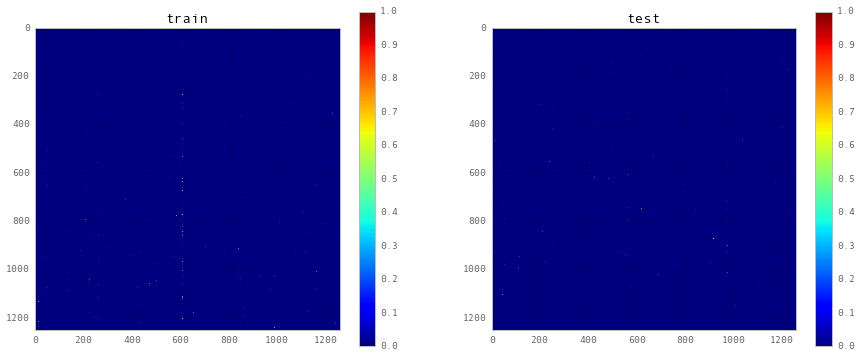

In [45]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
norm = np.sum(train_coo.todense(), axis=1)
idx = np.array(norm > 0).T[0]
td_train = train_coo.todense()[idx, :] / np.tile(norm[idx, :], (1, nb_tickers))
plt.title("train")
plt.imshow(td_train[1:, :])
plt.colorbar()

plt.subplot(2,2,2)
td_test = test_coo.todense()[idx, :] / np.tile(np.sum(test_coo.todense(), axis=1)[idx, :], (1, nb_tickers))
td_test[np.isnan(td_test)] = 0.
plt.title("test")
plt.imshow(td_test[1:, :])
plt.colorbar()

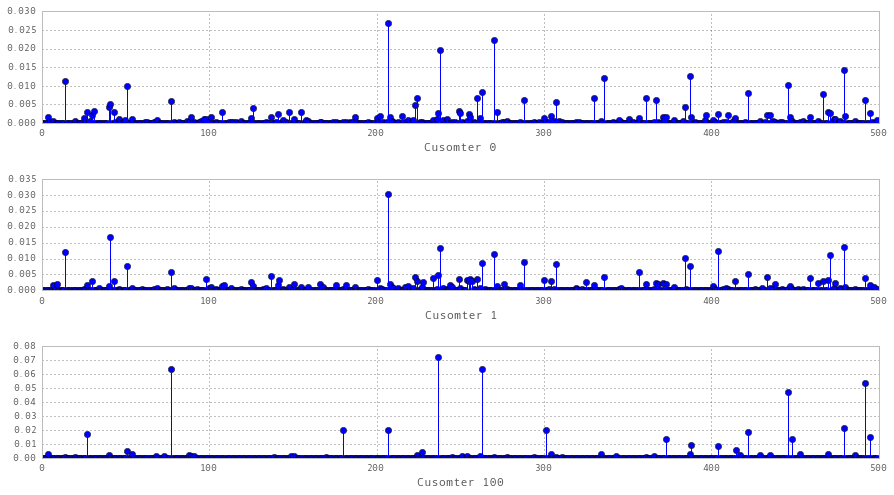

In [46]:
plt.figure(figsize=(15, 8))
plt.subplot(3,1,1)
plt.stem(np.array(td_train[0, :500])[0])
plt.xlabel("Cusomter 0")
plt.subplot(3,1,2)
plt.stem(np.array(td_train[1, :500])[0])
plt.xlabel("Cusomter 1")
plt.subplot(3,1,3)
plt.stem(np.array(td_train[100, :500])[0])
plt.xlabel("Cusomter 100")
plt.show()

### Training using NMF

In [47]:
import nimfa
from timeit import default_timer as timer

In [48]:
# Using dense matrices currently as they fit in memory 
# and are faster to train for an unknown reason.

start = timer()
model = nimfa.Nmf(td_train, seed='random_vcol', rank=10, max_iter=100)
mfit = model()
dt = timer() - start
print "Lsnmf created in %f s" % dt

Lsnmf created in 1.896401 s


In [49]:
print('Rss: %5.4f' % mfit.fit.rss())
print('Evar: %5.4f' % mfit.fit.evar())
print('K-L divergence: %5.4f' % mfit.distance(metric='kl'))
print('Sparseness, W: %5.4f, H: %5.4f' % mfit.fit.sparseness())

Rss: 98.3097
Evar: 0.3539
K-L divergence: 2968.6186
Sparseness, W: 0.6887, H: 0.7084


### Visualisation: t-SNE

In [50]:
from sklearn.manifold import TSNE

In [51]:
M = np.array(mfit.coef())
N = np.array(mfit.basis())

print nb_customers, nb_tickers
print M.shape
print N.shape

2030 1258
(10, 1258)
(1251, 10)


In [52]:
NM = N.dot(M)

In [53]:
tsne = TSNE(n_components=2, random_state=0)
T1 = tsne.fit_transform(td_train)

In [54]:
tsne = TSNE(n_components=2, random_state=0)
T2 = tsne.fit_transform(N)

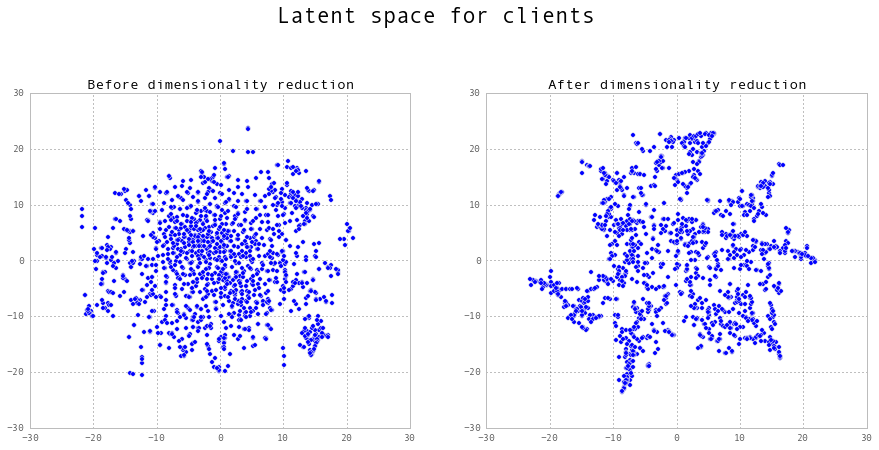

In [55]:
plt.figure(figsize=(15, 15))
plt.suptitle("Latent space for clients", size=22)
plt.subplot(2, 2, 1)
plt.scatter(T1[:, 0], T1[:, 1])
plt.title("Before dimensionality reduction")
plt.subplot(2, 2, 2)
plt.scatter(T2[:, 0], T2[:, 1])
plt.title("After dimensionality reduction")
plt.show()